           Image         X        Y       Z
330  p000330.jpg  118.9713 -68.6400  1.3812
331  p000331.jpg  119.0772 -69.7422  1.3805


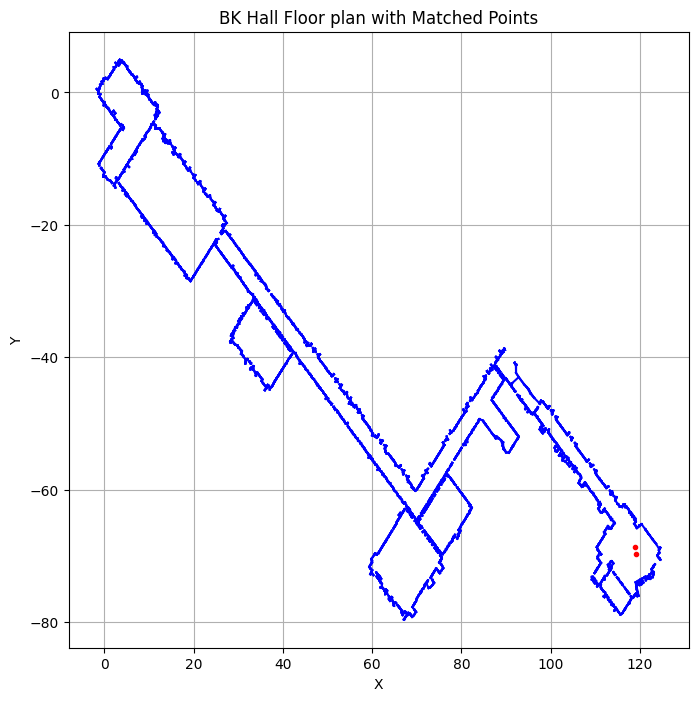

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

# Load the three CSV files
image_matching_df = pd.read_csv('Image matching validation sheet - Sheet1.csv')  # Replace with actual file path
orbit_import_df = pd.read_csv('orbit_import_camera.csv')  # Replace with actual file path
df = pd.read_csv('BK HALL wall edited.csv')  # Replace with actual file path

# Clean the 'Image' column in orbit_import_df by stripping extra spaces
orbit_import_df.columns = orbit_import_df.columns.str.strip()

# Function to get the corresponding XYZ coordinates based on the user image name
def get_xyz_coordinates_base(user_image_name):
    # Step 1: Extract the corresponding image names from the Image matching sheet
    matched_row = image_matching_df[image_matching_df['User image name (image you took)'] == user_image_name]
    
    if matched_row.empty:
        return f"No match found for {user_image_name}"
    
    # Get Ground Truth image names and ignore suffixes
    ground_truth_images = matched_row.iloc[0, 3:8].dropna().tolist()  # Extract relevant columns for Ground Truth images
    base_image_names = [img.split('_')[0] for img in ground_truth_images]  # Ignore suffixes like _right, _front
    
    # Step 2: Match these base image names with the data in orbit_import_camera
    matched_xyz = orbit_import_df[orbit_import_df['Image'].str.contains('|'.join(base_image_names))][['Image', 'X', 'Y', 'Z']]
    
    if matched_xyz.empty:
        return f"No XYZ coordinates found for base images {base_image_names}"
    
    return matched_xyz

# Step 1: Load the 2D points from the BK Hall wall CSV file and convert them to a NumPy array
points = df[['x', 'y']].values

# Step 2: Find the nearest neighbors for each point using KDTree
tree = KDTree(points)
# Query for the closest 3 points (excluding the point itself)
distances, indices = tree.query(points, k=4)  # k=4 to get more neighbors

# Step 3: Draw lines connecting each point to its closest neighbor if the distance is less than the threshold
threshold = 2  # in meters
lines = []
for i, dists in enumerate(distances):
    for j in range(1, len(dists)):  # Start from the 1st nearest neighbor (2nd index)
        if dists[j] < threshold:  # Only add lines for distances below the threshold
            nn = indices[i, j]
            line = [points[i], points[nn]]
            lines.append(line)

# Step 4: Visualize the lines (in blue) and plot the matched points (in red)
plt.figure(figsize=(8, 8))

# Draw the lines
for line in lines:
    plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], 'b-')

# Test the image matching function using 'validation_001.jpg' as an example and plot the matched points on the graph
result = get_xyz_coordinates_base('validation_001.jpg')

print(result)

# Step 5: Plot the red points from the image matching result (assuming you have 'X', 'Y' columns in `result`)
# This 'result' DataFrame should contain the X, Y coordinates of the matched points
for _, row in result.iterrows():
    plt.plot(row['X'], row['Y'], 'ro', markersize=3)  # Red points for matched images

plt.title('BK Hall Floor plan with Matched Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()
